In [1]:
!pip install -q pycaret

In [2]:
!pip install -q shapely

In [36]:
# native imports
import warnings

# utility imports
import pandas as pd
import numpy as np

# stats pkgs
import statsmodels.api as stat_model_api
import statsmodels as stat_model

# viz pkgs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# automl
import pycaret
from pycaret.regression import *

# DL pkgs
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# preprocessing pkgs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# metrics pkgs
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [4]:
# defaults

%matplotlib inline
warnings.filterwarnings("ignore")
matplotlib.rcParams["figure.figsize"] = [16, 9]
np.random.seed(45)

data_scaler = MinMaxScaler()

#1. EDA

> Loading the dataset

In [ ]:
dataset_path = "ts_data.csv"
ts_data = pd.read_csv(dataset_path)

ts_data.head(), ts_data.shape

> Displaying columns

In [6]:
ts_data.columns

Index(['time', 'Comms and Services', 'Car Chargers', 'Space Heating',
       'Hot Water', 'Sockets', 'Lighting', 'datepart', 'weekend',
       'bank holiday', 'hour', 'day of week', 'day of month', 'month', 'year',
       'forecast_datadate', 'forecastperiod', 'forecast_temperature',
       'forecast_feelslike', 'forecast_weathertype', 'forecast_windspeed',
       'forecast_uvindex', 'forecast_precipitationprobability',
       'forecast_winddirection', 'forecast_visibility', 'forecast_interval',
       'observationperiod', 'observation_temperature',
       'observation_winddirection', 'observation_windspeed',
       'observation_pressure', 'observation_dewpoint', 'observation_humidity'],
      dtype='object')

In [7]:
ts_data.time.is_unique

True

In [8]:
ts_data.time.nunique(), ts_data.shape

(720, (720, 33))

In [9]:
eda_data = ts_data.copy()

In [10]:
eda_data.head()

,time,Comms and Services,Car Chargers,Space Heating,Hot Water,Sockets,Lighting,datepart,weekend,bank holiday,...,forecast_winddirection,forecast_visibility,forecast_interval,observationperiod,observation_temperature,observation_winddirection,observation_windspeed,observation_pressure,observation_dewpoint,observation_humidity
0,2019-04-01 00:00:00+00,0.515253,0.032239,0.856489,0.000000,0.051467,0.124797,43556,False,False,...,NaN,NaN,NaN,2019-04-01 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-01 01:00:00+00,0.687381,0.042894,0.786147,0.085386,0.050931,0.151708,43556,False,False,...,NaN,NaN,NaN,2019-04-01 01:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-01 02:00:00+00,0.687678,0.043100,3.530669,0.099239,0.055706,0.151233,43556,False,False,...,NaN,NaN,NaN,2019-04-01 02:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-04-01 03:00:00+00,0.690139,0.043131,4.044003,0.098467,0.050019,0.151436,43556,False,False,...,NaN,NaN,NaN,2019-04-01 03:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-01 04:00:00+00,0.687081,0.043031,4.223769,0.091533,0.050142,0.151331,43556,False,False,...,NaN,NaN,NaN,2019-04-01 04:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# convert time mixed object column to datetime timestamp
eda_data["time"] = pd.to_datetime(eda_data["time"], format="%Y-%m-%d %H:%M:%S")

In [12]:
# checking the range of the time period
eda_data["time"].min(), eda_data["time"].max()

(Timestamp('2019-04-01 00:00:00+0000', tz='UTC'),
 Timestamp('2019-04-30 23:00:00+0000', tz='UTC'))

> - This shows that the time period of the data available is only for 1 month

In [13]:
# setting eda_data time as index for better slicing and parsing in pandas
eda_data = eda_data.set_index("time")

In [14]:
na_val = ((eda_data.isna().sum() / eda_data.shape[0]) * 100)
na_val = na_val.reset_index().rename(columns={"index": 'columns', 0: "missing_percent"})
na_val.head()

,columns,missing_percent
0,Comms and Services,1.527778
1,Car Chargers,1.527778
2,Space Heating,1.527778
3,Hot Water,1.527778
4,Sockets,1.527778


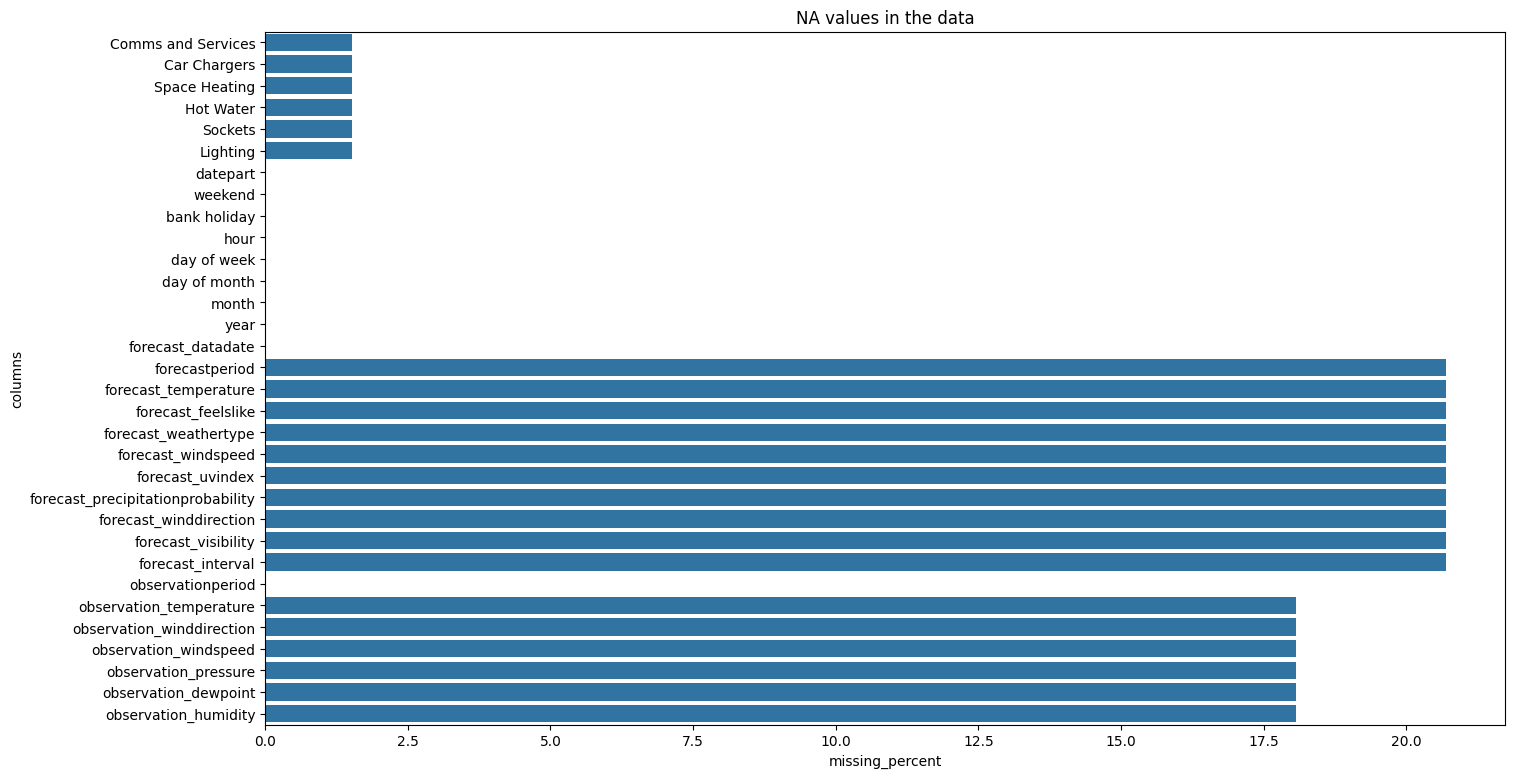

In [15]:
ax = sns.barplot(data=na_val, x="missing_percent", y="columns")
ax.set_title("NA values in the data")
plt.show()

> - There are features with `20%` of the data with NA values.


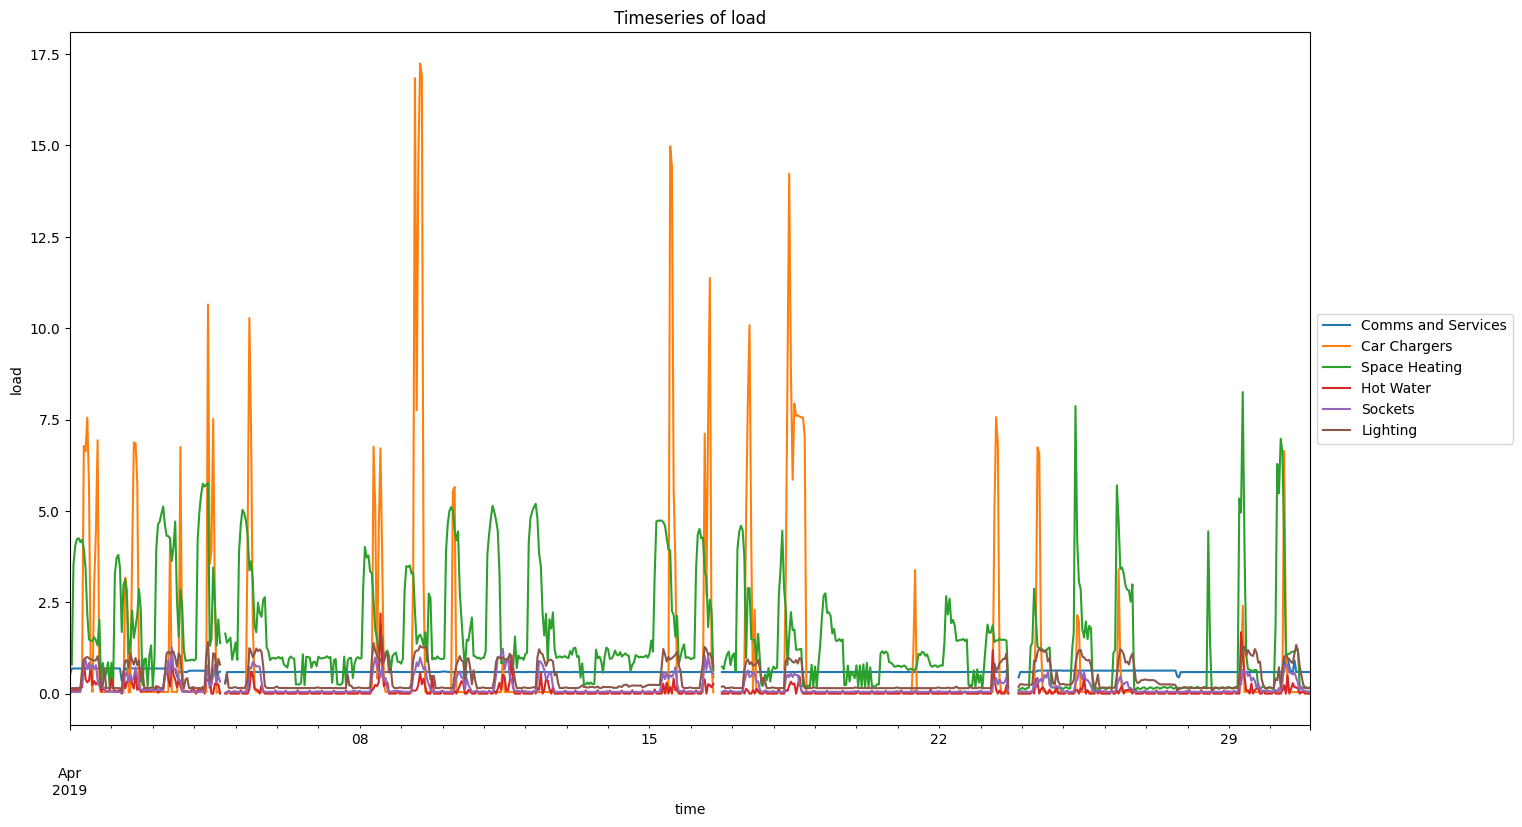

In [16]:
load_columns = ['Comms and Services', 'Car Chargers', 'Space Heating', 'Hot Water', 'Sockets', 'Lighting']
eda_data.plot(y=load_columns)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("load")
plt.title("Timeseries of load")
plt.show()

> - From the above plot, it can be inferred that majority of the load across 1 month data is from `top 3 -`  `Car Chargers`, `Space Heating` and `Comms and services`

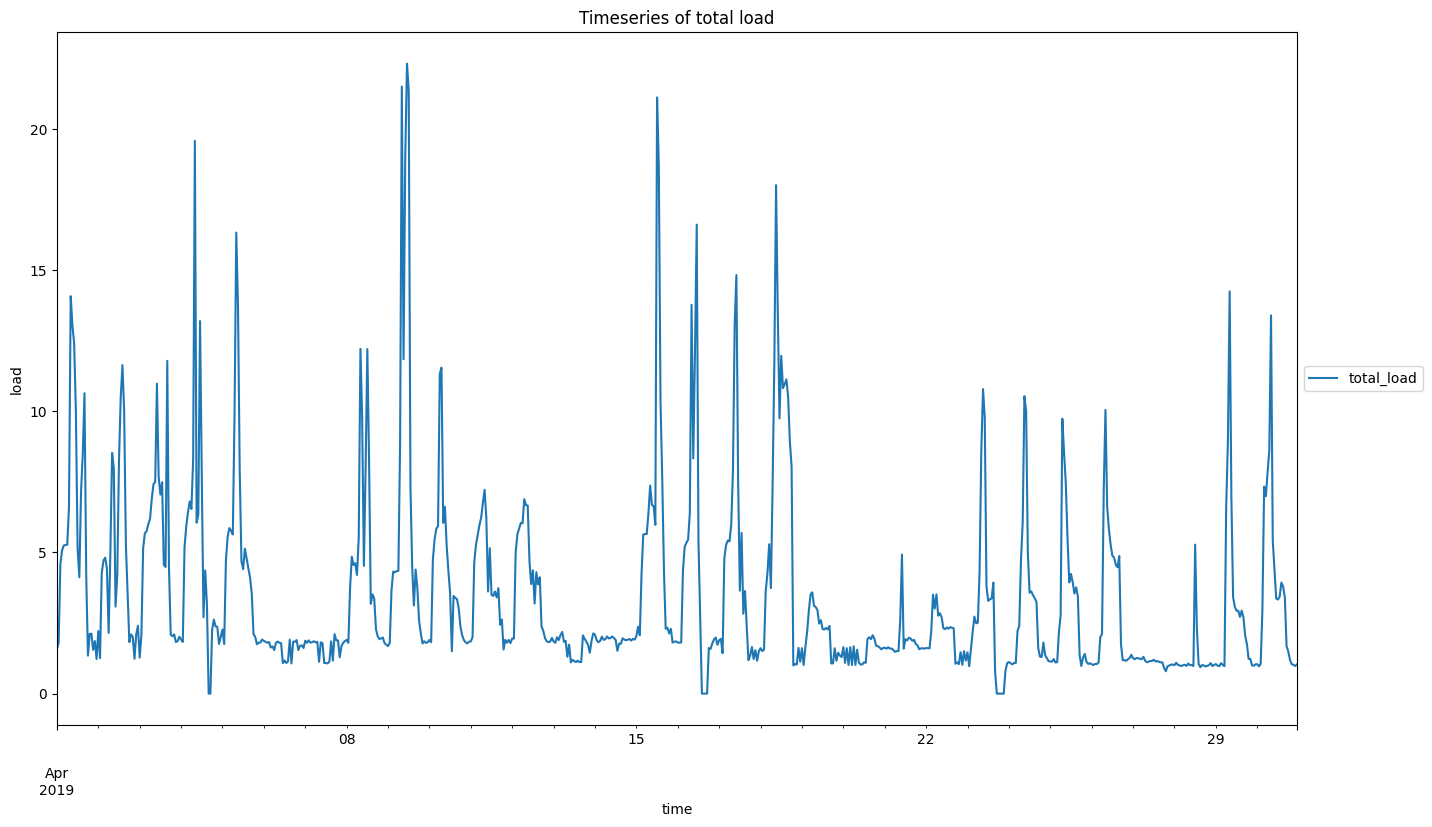

In [17]:
# checking the total load
eda_data["total_load"] = eda_data[load_columns].sum(axis=1)
eda_data.plot(y="total_load")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylabel("load")
plt.title("Timeseries of total load")
plt.show()

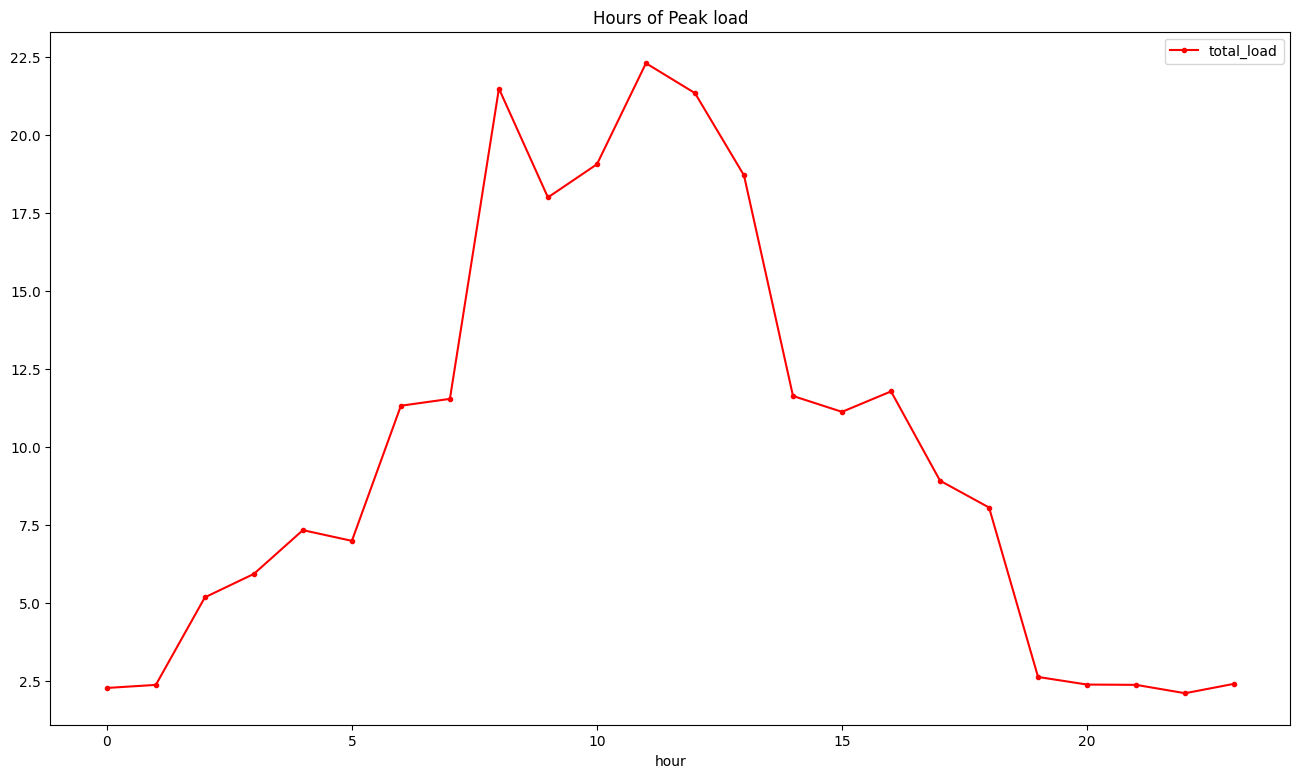

In [18]:
# check what are the hours of the peak load
eda_data.groupby("hour").aggregate({"total_load": "max"}).reset_index().plot(x="hour", y="total_load", kind="line", c="red", style=".-")
plt.title("Hours of Peak load")
plt.show()

> The above figure shows that, from the given 1 month data, the maximum load drawn is between `5 am and 5 pm`

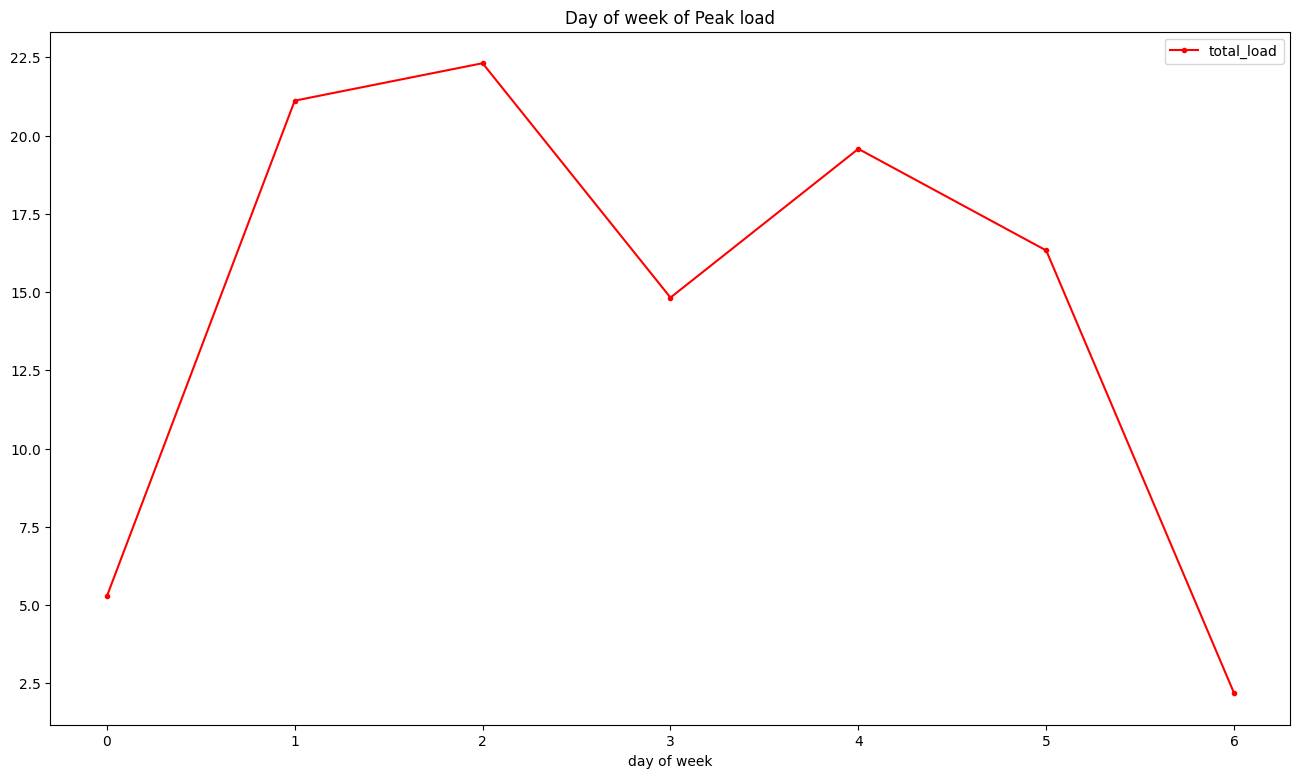

In [19]:
# check which days have peak total load
eda_data.groupby("day of week").aggregate({"total_load": "max"}).reset_index().plot(x="day of week", y="total_load", kind="line", c="red", style='.-')
plt.title("Day of week of Peak load")
plt.show()

> - The above figure shows that maximum load drawn was on `monday - tuesday  &thursday - friday`
> - point to think: why does the load drops on wednesday ?

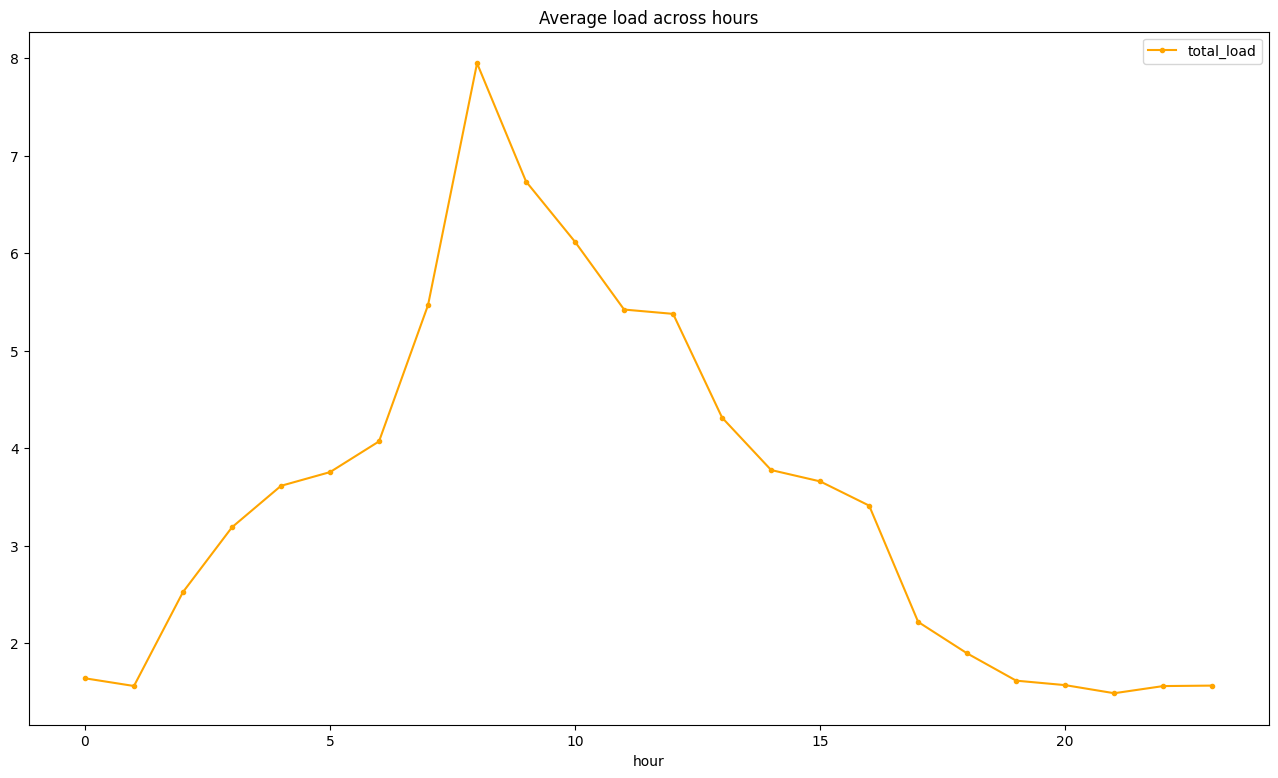

In [20]:
# checking average load utilization across hours in the month
eda_data.groupby("hour").aggregate({"total_load": "mean"}).reset_index().plot(x="hour", y="total_load", kind="line", c="orange", style=".-")
plt.title("Average load across hours")
plt.show()

> - The above figure shows that, average utilization raises at `1 am`, peaks around `9 am`, and drops post `9 am`


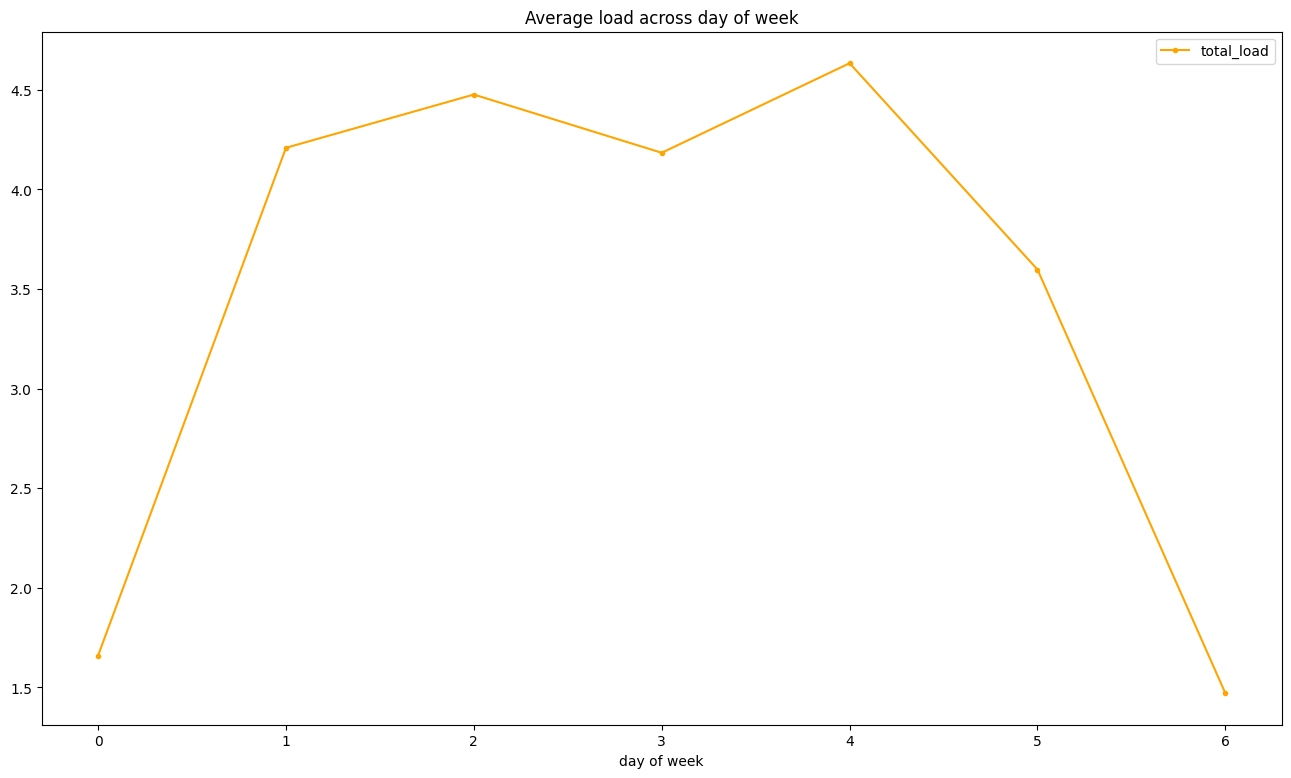

In [21]:
# checking average load utilization across hours in the month
eda_data.groupby("day of week").aggregate({"total_load": "mean"}).reset_index().plot(x="day of week", y="total_load", kind="line", c="orange", style=".-")
plt.title("Average load across day of week")
plt.show()

> - The above figure shows that, average utilization is active between `Mon-Fri` and a drop on `Wed`

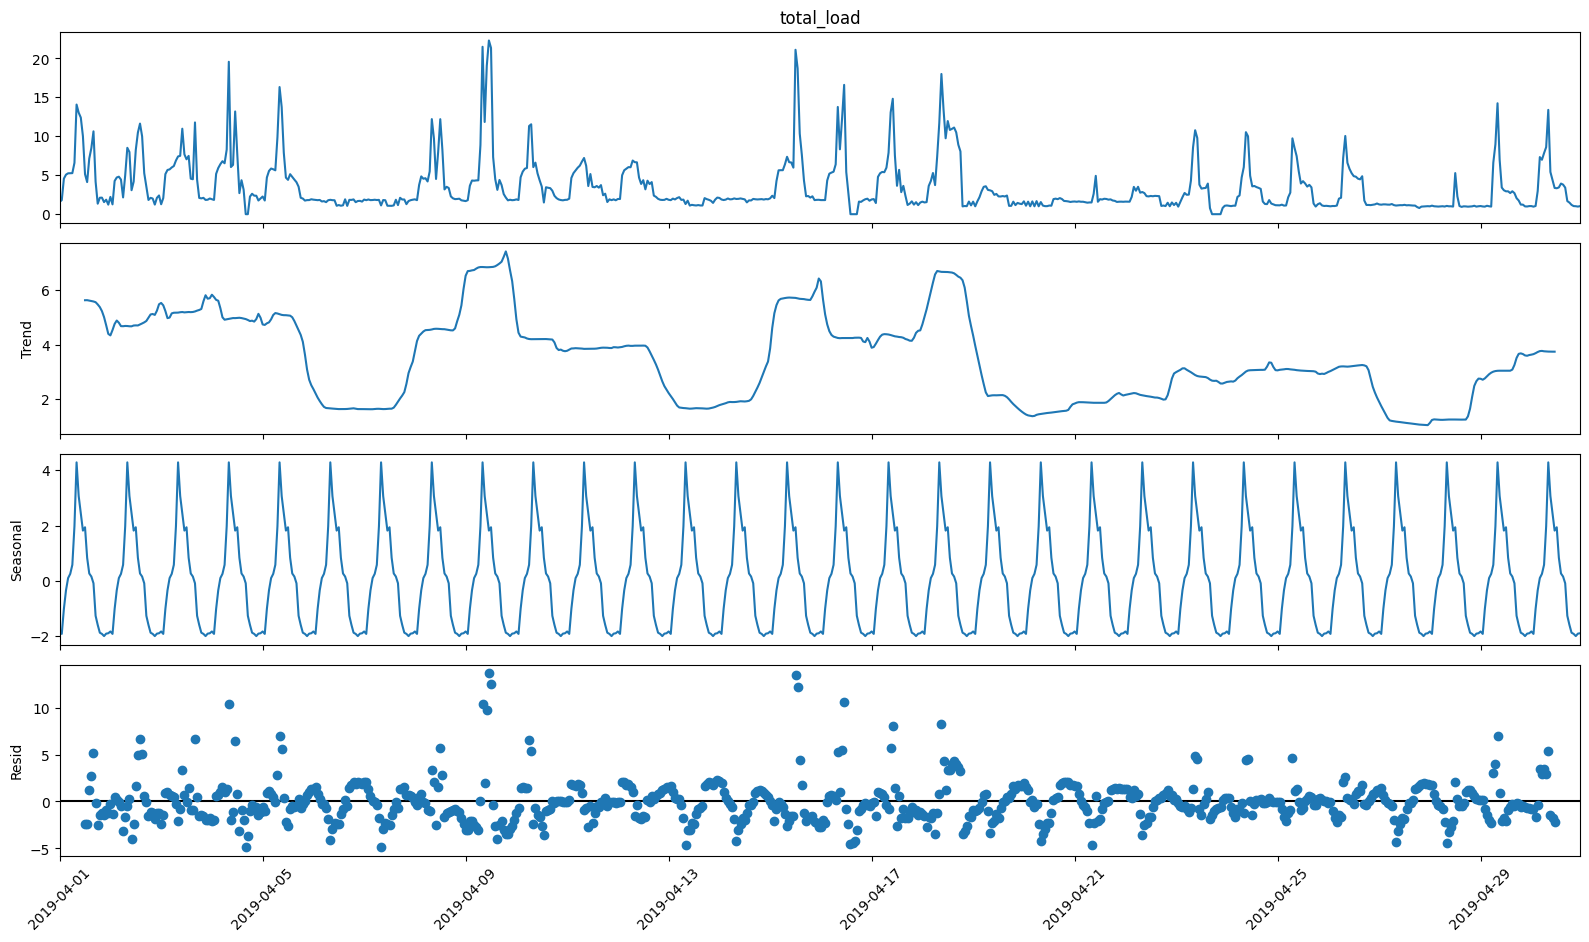

In [22]:
# check for seasonality on total load of the data

decomposition = stat_model_api.tsa.seasonal_decompose(
    eda_data["total_load"], model="additive"
)

fig = decomposition.plot()
plt.xticks(rotation=45)
plt.show()

> From the above figure there is no trend or seasonality observed. There are localised peaks in the time frames but the forecast data can be considered stationary

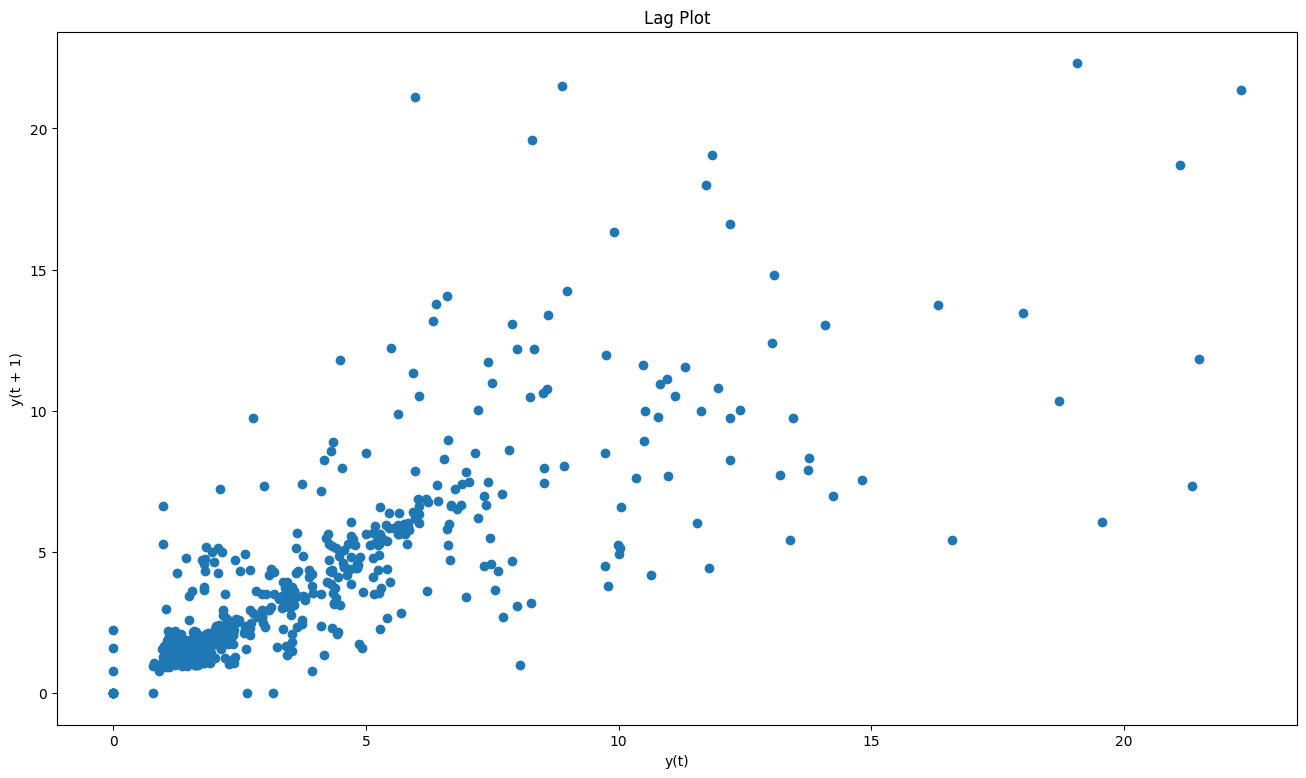

In [23]:
# check the correlation of total load with the lag plot
ax = pd.plotting.lag_plot(eda_data["total_load"])
ax.set_title("Lag Plot")
plt.show()

> The plot shows that there exists a positive correlation between the lag at current time $t$ and lag shifted to $t+1$

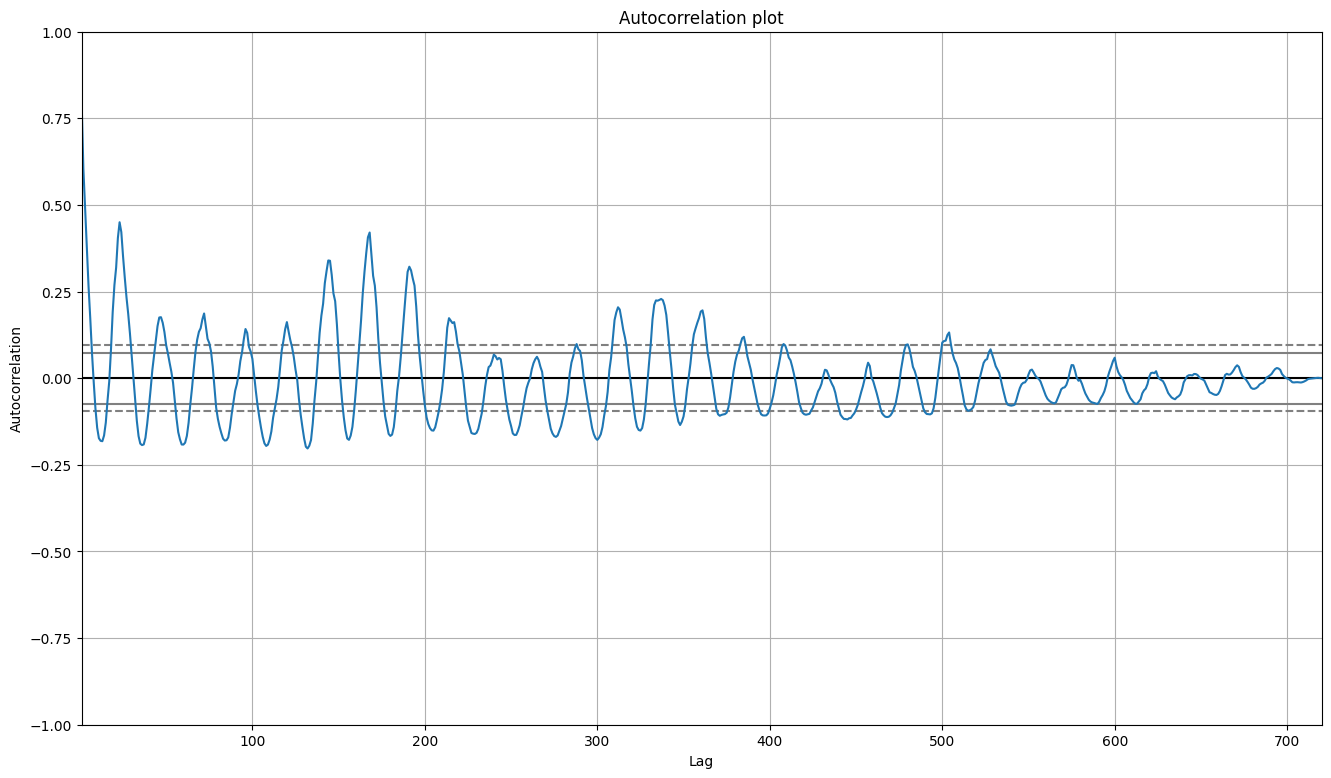

In [24]:
# check autocorrelation with the total load
ax = pd.plotting.autocorrelation_plot(eda_data["total_load"])
ax.set_title("Autocorrelation plot")
plt.show()

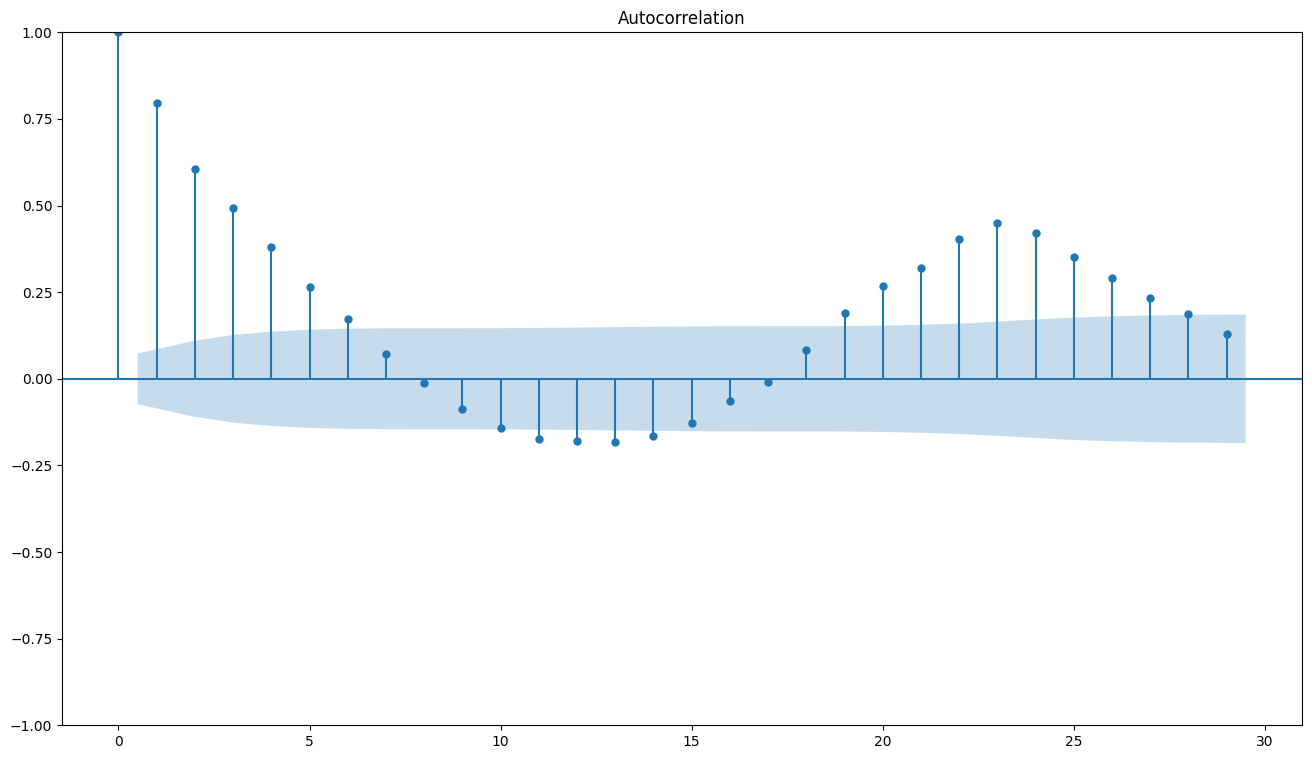

In [25]:
# checking the points using the autocorrelation function from the statsmodels
stat_model.graphics.tsaplots.plot_acf(eda_data["total_load"])
plt.show()

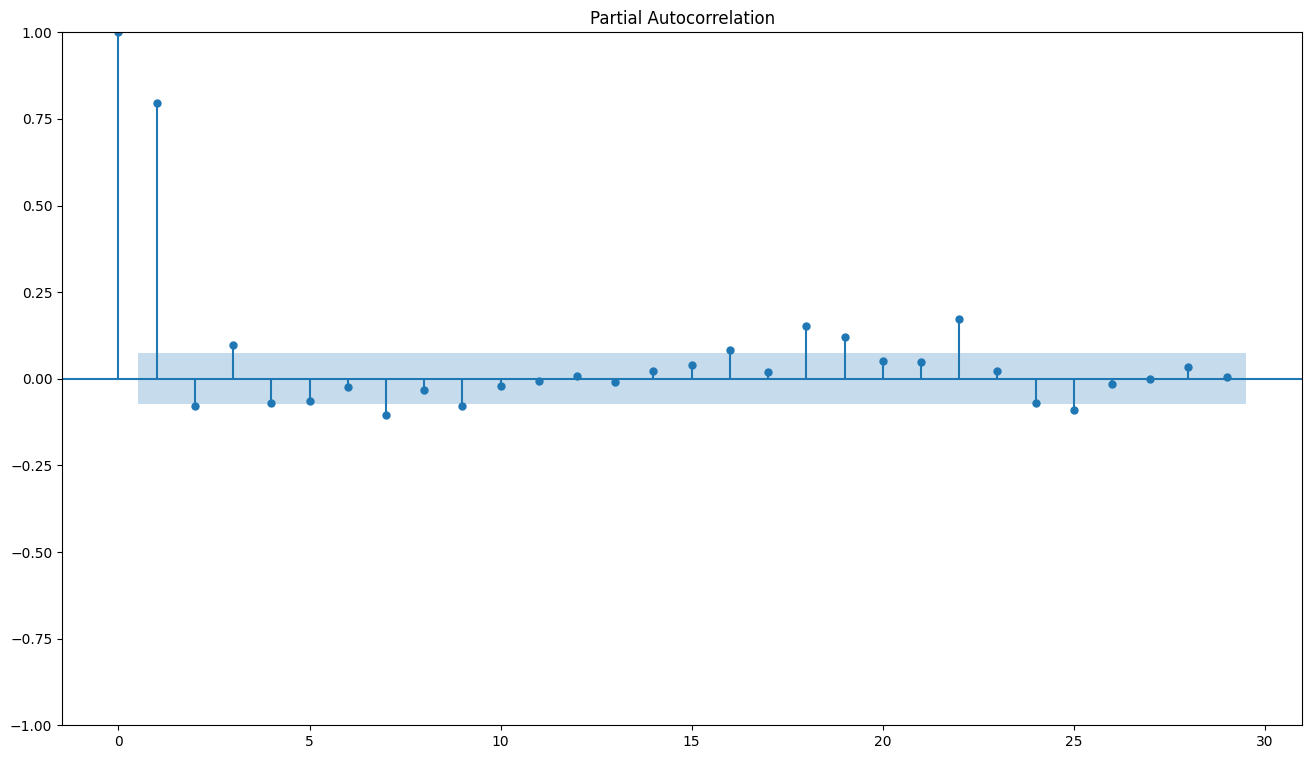

In [26]:
# checking the points using the partial autocorrelation function fomr the statsmodels
stat_model.graphics.tsaplots.plot_pacf(eda_data["total_load"])
plt.show()

> From the above autocorrelation figures, the maximum number of consecutive points that lie between the confidence intervals is 6, which means that $p=6$ can be considered for `ARMA` type statistical models

In [27]:
# experiment with classical ml models

# consider only the features that are derived from the temporal component
eda_data = eda_data.rename(
    columns={"bank holiday": "bank_holiday", "day of week": "day_of_week", "day of month": "day_of_month"}
)
feature_columns = ["weekend", "bank_holiday", "hour", "day_of_week", "day_of_month", "month", "year"]
target_column = ["total_load"]

model_data = eda_data[feature_columns+target_column]
eda_data.shape, model_data.shape

((720, 33), (720, 8))

In [49]:
def data_transform(data, raw=False, reshape_dim=False, all_cols=True, fit_scale_data=True):
  """
  A function to transform and create lag variables as per the given time series
  columns

  Args:
    data: pd.DataFrame: data to be transformed
    raw: bool: return boolean or not
    reshape_dim: bool: reshape the last dimension of the array
    all_cols: bool: return all feature columns else return only lag variables

  Return:
    x_train: np.array: array with feature values
    y_train: np.array: array with target values
    data: pd.dataframe: raw dataframe containing all columns

  """
  # scale the values of total load for numerical stability and efficiency
  global data_scaler
  if fit_scale_data:
    data_scaler = data_scaler.fit(data[['total_load']])

  data["total_load"] = data_scaler.transform(data[['total_load']])
  data["y_t+1"] = data["total_load"].shift(-1, freq="H")
  for t in range(1, t_window +1):
      t_shift = t_window - t
      col_name = "y_t-{}".format(t)
      data[col_name] = data["total_load"].shift(t_shift, freq="H")
  data = data.dropna(how="any")

  if not all_cols:
    x_cols = ["y_t-{}".format(i) for i in range(1, t_window + 1)]
    y_cols = ["y_t+1"]
    x_train = data[x_cols].to_numpy()
    y_train = data[y_cols].to_numpy()

  if reshape_dim:
    x_train = x_train.reshape(x_train.shape[0], t_window, 1)

  if raw:
      return data

  return x_train, y_train

In [30]:
# create lag variables

t_window = 5  # past time window to consider for future forecasting
horizon = 1  # the length of the forecast

data = data_transform(model_data, raw=True)

In [31]:
model_data.head()

,weekend,bank_holiday,hour,day_of_week,day_of_month,month,year,total_load,y_t+1,y_t-1,y_t-2,y_t-3,y_t-4,y_t-5
time,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,False,False,0,1,1,4,2019,0.070833,0.080883,NaN,NaN,NaN,NaN,0.070833
2019-04-01 01:00:00+00:00,False,False,1,1,1,4,2019,0.080883,0.204741,NaN,NaN,NaN,0.070833,0.080883
2019-04-01 02:00:00+00:00,False,False,2,1,1,4,2019,0.204741,0.227582,NaN,NaN,0.070833,0.080883,0.204741
2019-04-01 03:00:00+00:00,False,False,3,1,1,4,2019,0.227582,0.235188,NaN,0.070833,0.080883,0.204741,0.227582
2019-04-01 04:00:00+00:00,False,False,4,1,1,4,2019,0.235188,0.236011,0.070833,0.080883,0.204741,0.227582,0.235188


In [32]:
# transform weekend and bank_holiday fields
data["weekend"] = data["weekend"].astype(int)
data["bank_holiday"] = data["bank_holiday"].astype(int)

# drop the total_load column as y_t+1 is the target values
data = data.drop(columns=["total_load"], axis=1)
data.shape

(715, 13)

In [34]:
# splitting into x train and validation
train_data, test_data = train_test_split(
    data, test_size=0.3, random_state=54, shuffle=False
)
train_data.shape, test_data.shape

((500, 13), (215, 13))

In [35]:
# splitting validation into test amd validation
validation_data, test_data = train_test_split(
    test_data,
    test_size=0.5, random_state=45, shuffle=False
)
validation_data.shape, test_data.shape

((107, 13), (108, 13))

> - Try out `pycaret` ( automl ) to check the type of model that can best capture the data for fast experimentation
> - This is a `single step multivariate forecasting` example with multivariate regression with only the features extracted from temporal component



In [37]:
train_data.columns

Index(['weekend', 'bank_holiday', 'hour', 'day_of_week', 'day_of_month',
       'month', 'year', 'y_t+1', 'y_t-1', 'y_t-2', 'y_t-3', 'y_t-4', 'y_t-5'],
      dtype='object')

In [38]:
numeric_features = set(train_data.columns.to_list()) - set(["y_t+1"])
numeric_features = list(numeric_features)
numeric_features

['day_of_month',
 'y_t-4',
 'hour',
 'y_t-1',
 'y_t-2',
 'y_t-3',
 'month',
 'bank_holiday',
 'year',
 'weekend',
 'y_t-5',
 'day_of_week']

In [39]:
pycaret_s  = setup(
    data = train_data,
    test_data = validation_data,
    target="y_t+1",
    fold_strategy="timeseries",
    numeric_features = numeric_features,
    fold=4,
    transform_target=True,
    session_id = 123,
    data_split_shuffle=False,
    fold_shuffle=False
)

,Description,Value
0,Session id,123
1,Target,y_t+1
2,Target type,Regression
3,Original data shape,"(607, 13)"
4,Transformed data shape,"(607, 13)"
5,Transformed train set shape,"(500, 13)"
6,Transformed test set shape,"(107, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


In [40]:
best = compare_models(sort="MAE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0183,0.0044,0.0333,0.1349,0.0216,0.1336,0.0450
ridge,Ridge Regression,0.0483,0.0099,0.0855,0.4163,0.0610,0.3340,0.0725
huber,Huber Regressor,0.0523,0.0113,0.0902,0.3864,0.0627,0.3690,0.0700
ada,AdaBoost Regressor,0.0562,0.0115,0.1043,0.5271,0.0740,0.3541,0.1300
et,Extra Trees Regressor,0.0565,0.0124,0.1077,0.4795,0.0766,0.3602,0.1925
rf,Random Forest Regressor,0.0587,0.0120,0.1062,0.4743,0.0754,0.3738,0.2650
lightgbm,Light Gradient Boosting Machine,0.0588,0.0129,0.1094,0.4817,0.0781,0.3772,0.2125
gbr,Gradient Boosting Regressor,0.0637,0.0145,0.1180,0.3189,0.0843,0.4089,0.1475
xgboost,Extreme Gradient Boosting,0.0713,0.0183,0.1331,0.0942,0.0952,0.4542,0.1575
dt,Decision Tree Regressor,0.0929,0.0315,0.1643,-1.4291,0.1142,0.5562,0.0450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

> - Above table suggests that for single step multivariate timeseries forecast, `Bayesian Ridge ` performs better
> - Since the dataset is tiny, it makes sense that BR came out to be useful, but with large datataset probably `RandomForestRegressors`, `Adaboost`, `ExtraTrees` are likely to be turned up as best models.
> - Next, predict over holdout test and visualize  the predicted values

In [42]:
predictions = predict_model(best, data=test_data[numeric_features])

In [43]:
predictions = predictions.join(test_data[["y_t+1"]])
plot_data = predictions[["prediction_label", "y_t+1"]]
plot_data.head()

,prediction_label,y_t+1
time,,
2019-04-26 11:00:00+00:00,0.152225,0.218880
2019-04-26 12:00:00+00:00,0.133614,0.215789
2019-04-26 13:00:00+00:00,0.135993,0.204393
2019-04-26 14:00:00+00:00,0.130427,0.200540
2019-04-26 15:00:00+00:00,0.127340,0.218432


In [44]:
plot_data = plot_data.rename(columns={
    "prediction_label": "prediction",
    "y_t+1": "actual"
})
plot_data[["prediction", "actual"]] = data_scaler.inverse_transform(plot_data[["prediction", "actual"]])

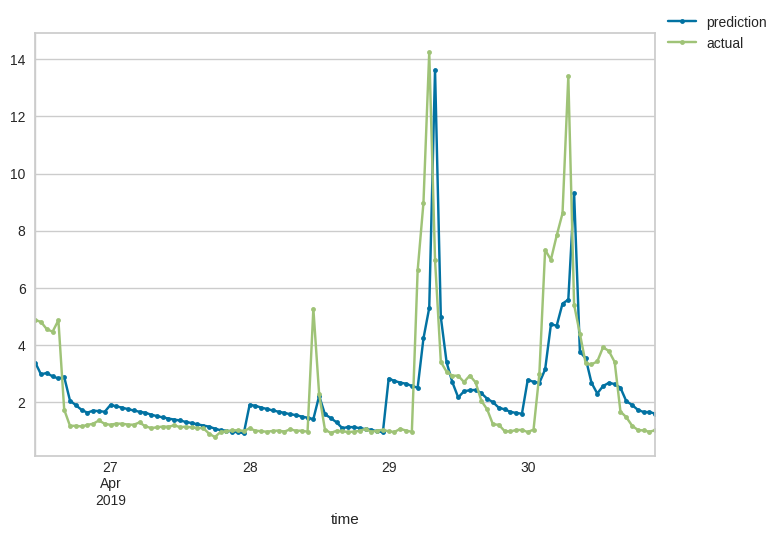

In [45]:
plot_data.plot(style='.-')
plt.legend(loc="center left", bbox_to_anchor=(1, 1))
plt.show()

In [46]:
mean_absolute_percentage_error(plot_data["prediction"], plot_data["actual"])

0.3837145898616434

In [48]:
mean_absolute_error(plot_data["prediction"], plot_data["actual"])

1.056144966838713

> Forecasting for 4 hours

In [50]:
# taking the last record for futurre forecasting
forecast_data = test_data.tail(1)
forecast_data = forecast_data.drop(columns=["y_t+1"], axis=1)

In [51]:
from datetime import timedelta

In [52]:
forecast_data.index[0]

Timestamp('2019-04-30 22:00:00+0000', tz='UTC')

In [53]:
# creating the data for plotting the forecas
new_data = pd.DataFrame({})
new_data["value"] = [forecast_data[f"y_t-{i}"].item() for i in range(5, 0, -1)]
new_data["time"] = [forecast_data.index[0] - timedelta(hours=i) for i in range(5, 0, -1)]
new_data["source"] = "actual"
new_data

,value,time,source
0,0.043801,2019-04-30 17:00:00+00:00,actual
1,0.045804,2019-04-30 18:00:00+00:00,actual
2,0.046593,2019-04-30 19:00:00+00:00,actual
3,0.053465,2019-04-30 20:00:00+00:00,actual
4,0.066673,2019-04-30 21:00:00+00:00,actual


In [54]:
start_time = new_data.iloc[-1]["time"]
start_time

Timestamp('2019-04-30 21:00:00+0000', tz='UTC')

In [55]:
[start_time + timedelta(hours=i) for i in range(0, 5)]

[Timestamp('2019-04-30 21:00:00+0000', tz='UTC'),
 Timestamp('2019-04-30 22:00:00+0000', tz='UTC'),
 Timestamp('2019-04-30 23:00:00+0000', tz='UTC'),
 Timestamp('2019-05-01 00:00:00+0000', tz='UTC'),
 Timestamp('2019-05-01 01:00:00+0000', tz='UTC')]

In [56]:
forecast_horizon = [start_time + timedelta(hours=i) for i in range(0, 5)]
for elem in forecast_horizon:
  last_data = forecast_data.tail(1)
  next_prediction = predict_model(best, data=last_data)["prediction_label"].item()

  tmp = pd.DataFrame({
      "weekend": [0],
      "bank_holiday": [0],
      "hour": [elem.hour],
      "day_of_week": [elem.weekday()],
      "day_of_month": [elem.day],
      "month": [elem.month],
      "year": [elem.year],
      "y_t-1": [next_prediction],
  })

  for i in range(5, 1, -1):
    tmp[f"y_t-{i}"] = last_data[f"y_t-{i-1}"].item()

  tmp['time'] = elem
  new_tmp = tmp[["time", "y_t-1"]]
  tmp = tmp.set_index("time")

  forecast_data = pd.concat([forecast_data, tmp], axis=0, ignore_index=True)
  new_tmp = new_tmp.rename(columns={
      "y_t-1": "value"
  })
  new_tmp["source"] = "forecast"
  new_data = pd.concat([new_data, new_tmp], axis=0, ignore_index=True)


In [57]:
new_data = new_data.set_index("time")

In [60]:
new_data["value"] = data_scaler.inverse_transform(new_data[['value']])
new_data.head()

,value,source
time,,
2019-04-30 17:00:00+00:00,0.977169,actual
2019-04-30 18:00:00+00:00,1.021850,actual
2019-04-30 19:00:00+00:00,1.039467,actual
2019-04-30 20:00:00+00:00,1.192769,actual
2019-04-30 21:00:00+00:00,1.487439,actual


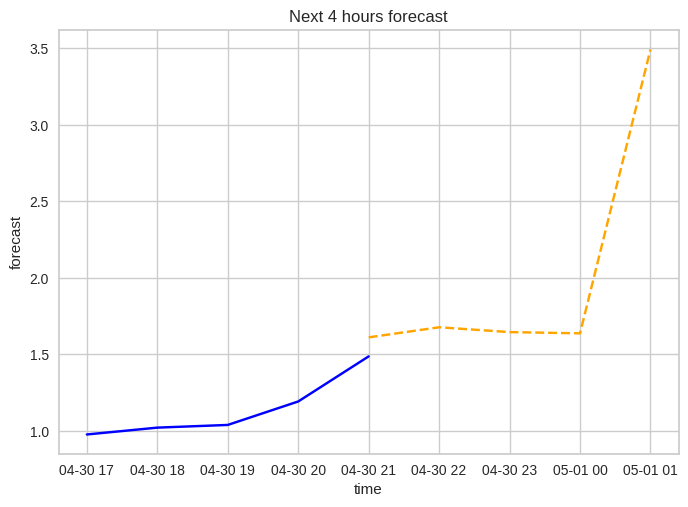

In [61]:
plt.plot(new_data[new_data["source"] == "actual"][["value"]], c="blue", linestyle="solid")
plt.plot(new_data[new_data["source"] == "forecast"][["value"]], c="orange", linestyle="dashed")
plt.title("Next 4 hours forecast")
plt.xlabel("time")
plt.ylabel("forecast")
plt.show()

#2. Modelling

### Hyperparameter tuning the extra trees regressor

In [62]:
best.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': None,
 'n_iter': 'deprecated',
 'tol': 0.001,
 'verbose': False}

In [63]:
tuned_best = tune_model(
    best, n_iter=100,
    search_algorithm="random")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1248,0.0377,0.1941,0.0242,0.1402,1.0294
1,0.0526,0.0288,0.1697,-2.2313,0.0912,0.2846
2,0.0730,0.0183,0.1352,0.4063,0.0956,0.3506
3,0.0508,0.0084,0.0918,0.5957,0.0676,0.4101
Mean,0.0753,0.0233,0.1477,-0.3013,0.0987,0.5187
Std,0.0299,0.0110,0.0385,1.1331,0.0262,0.2982


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 4 folds for each of 100 candidates, totalling 400 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [64]:
tuned_best.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'lambda_init': None,
 'max_iter': None,
 'n_iter': 'deprecated',
 'tol': 0.001,
 'verbose': False}

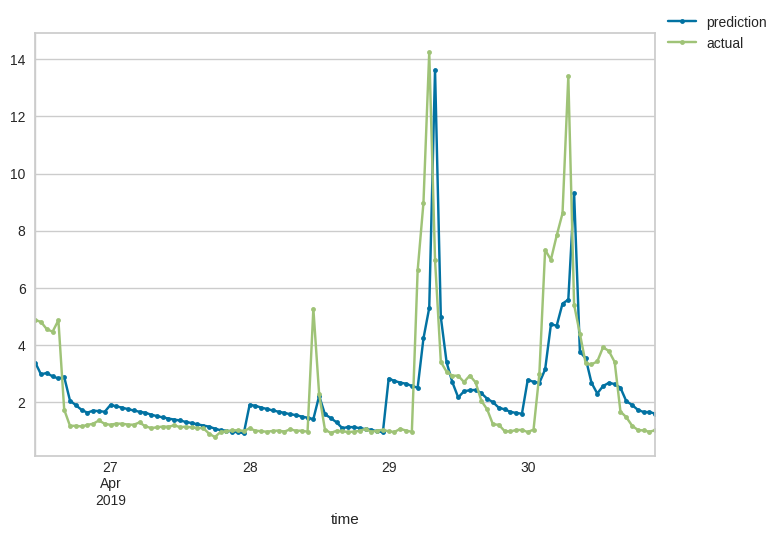

In [65]:
predictions = predict_model(tuned_best, data=test_data[numeric_features])
predictions = predictions.join(test_data[["y_t+1"]])
plot_data = predictions[["prediction_label", "y_t+1"]]
plot_data = plot_data.rename(columns={
    "prediction_label": "prediction",
    "y_t+1": "actual"
})
plot_data[["prediction", "actual"]] = data_scaler.inverse_transform(plot_data[["prediction", "actual"]])
plot_data.plot(style='.-')
plt.legend(loc="center left", bbox_to_anchor=(1, 1))
plt.show()

In [66]:
mean_absolute_percentage_error(plot_data["prediction"], plot_data["actual"]), mean_absolute_error(plot_data["prediction"], plot_data["actual"])

(0.3837145898616434, 1.056144966838713)

> - Here, the `MAPE` and `MAE` values have not much improvement in comparison to the base model, thus it can be concluded that, hyperparameter tuned model with the `n_iter=100` has led to slight improvement.


## Modelling with GRU networks


> - GRU (Gated recurrent units) is similar to LSTM, but simpler, faster and improved version of LSTM

In [118]:
from collections import UserDict
class TimeSeriesTensor(UserDict):
    """A dictionary of tensors for input into the RNN model.

    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.to_numpy()
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].to_numpy()
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [122]:
cols = ["weekend", "bank_holiday", "hour", "day_of_week", "day_of_month", "month", "year", "total_load"]
k_model_data = model_data[cols]
k_model_data["weekend"] = k_model_data["weekend"].astype(int)
k_model_data["bank_holiday"] = k_model_data["bank_holiday"].astype(int)

In [123]:
ktrain_data, ktest_data = train_test_split(k_model_data, test_size=0.3, shuffle=False)

ktest_data, kval_data = train_test_split(ktest_data, test_size=0.5, shuffle=False)

ktrain_data.shape, ktest_data.shape, kval_data.shape

((504, 8), (108, 8), (108, 8))

In [124]:
t_windows = 6 # established above in the pacf plot
horizon = 1   # forecast horizon
tensor = {"X": (range(-t_windows + 1, 1), cols)}
train_inp = TimeSeriesTensor(
    dataset=ktrain_data,
    target="total_load",
    H=horizon,
    tensor_structure=tensor,
    freq="H",
    drop_incomplete=True
)

test_inp = TimeSeriesTensor(
    dataset=ktest_data,
    target="total_load",
    H=horizon,
    tensor_structure=tensor,
    freq="H",
    drop_incomplete=True
)

val_inp = TimeSeriesTensor(
    dataset=kval_data,
    target="total_load",
    H=horizon,
    tensor_structure=tensor,
    freq="H",
    drop_incomplete=True
)


In [125]:
train_inp["X"].shape

(498, 6, 8)

In [126]:
# build a sample model
model = Sequential()
model.add(GRU(5, input_shape=(6, 8)))  # 6 = time windows, 8 = num features
model.add(Dense(1))
model.compile(optimizer="Adam", loss="mae")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 5)                 225       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 231 (924.00 Byte)
Trainable params: 231 (924.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
model_history = model.fit(
    train_inp["X"], train_inp["target"],
    batch_size=5, epochs=50,
    validation_data=(val_inp["X"], val_inp["target"]),
    callbacks=[early_stop],
    verbose=1
)

Train on 498 samples, validate on 102 samples
Epoch 1/50
498/498 [==============================] - 1s 2ms/sample - loss: 0.6089 - val_loss: 0.5041
Epoch 2/50
498/498 [==============================] - 1s 2ms/sample - loss: 0.4089 - val_loss: 0.3041
Epoch 3/50
498/498 [==============================] - 1s 1ms/sample - loss: 0.2089 - val_loss: 0.1041
Epoch 4/50
498/498 [==============================] - 1s 2ms/sample - loss: 0.0323 - val_loss: 0.0034
Epoch 5/50
498/498 [==============================] - 1s 2ms/sample - loss: 0.0048 - val_loss: 0.0035
Epoch 6/50
498/498 [==============================] - 0s 662us/sample - loss: 0.0047 - val_loss: 0.0036
Epoch 7/50
498/498 [==============================] - 0s 660us/sample - loss: 0.0047 - val_loss: 0.0039
Epoch 8/50
498/498 [==============================] - 0s 704us/sample - loss: 0.0047 - val_loss: 0.0049
Epoch 9/50
498/498 [==============================] - 0s 879us/sample - loss: 0.0047 - val_loss: 0.0038


In [129]:
predictions = model.predict(test_inp["X"])

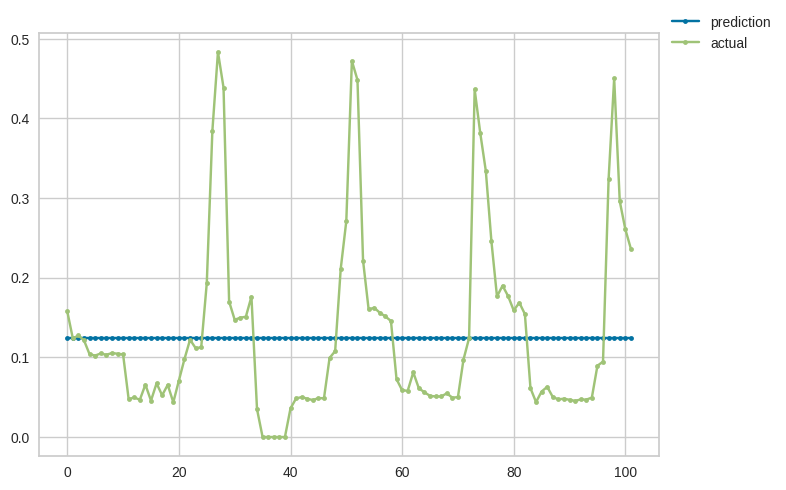

In [130]:
plot_data = pd.DataFrame({
    "prediction": predictions.reshape(-1).tolist(),
    "actual": test_inp["target"].reshape(-1).tolist()
})
plot_data[["prediction", "actual"]] = data_scaler.inverse_transform(plot_data[["prediction", "actual"]])
plot_data.plot(style='.-')
plt.legend(loc="center left", bbox_to_anchor=(1, 1))
plt.show()

In [131]:
mean_absolute_percentage_error(plot_data["prediction"], plot_data["actual"]), mean_absolute_error(plot_data["prediction"], plot_data["actual"])

(0.66567331451868, 0.08291441357792674)

> - Even though the `MAE` value is lesser than the classical model, the `MAPE` value is higher indicating the model is underfitting and have high bias.

> - `Future Scope`: Need more data to train the model to achieve a better model

#3. Feature Engineering


> - Understanding the impact of feature using SHAP or PDP plots a way to feature select

In [86]:
import shap

In [90]:
for i, _feature in enumerate(numeric_features):
  print(_feature, "=", tuned_best.coef_[i].round (5))

day_of_month = -0.00031
y_t-4 = 0.00256
hour = -0.00116
y_t-1 = -0.01993
y_t-2 = 0.00228
y_t-3 = 0.02141
month = -0.0
bank_holiday = -0.0105
year = -0.0
weekend = -0.01965
y_t-5 = 0.11101
day_of_week = -0.00027


> - Since BR is a probabilistic  regression model it is possible to check the modelcoefficients, but the magnitude of the coefficients from the linear model is not completely a good measure of feature importances

> - The coefficients gives a general association towards the output values, -ve coefficient indicate that negatively influenced and +ve coefficient indidicate positive association

> - Here, the `y_t-5` has the highest coefficient, which suggests that the prediction output at time $t$ depends majorly on time $t-1$


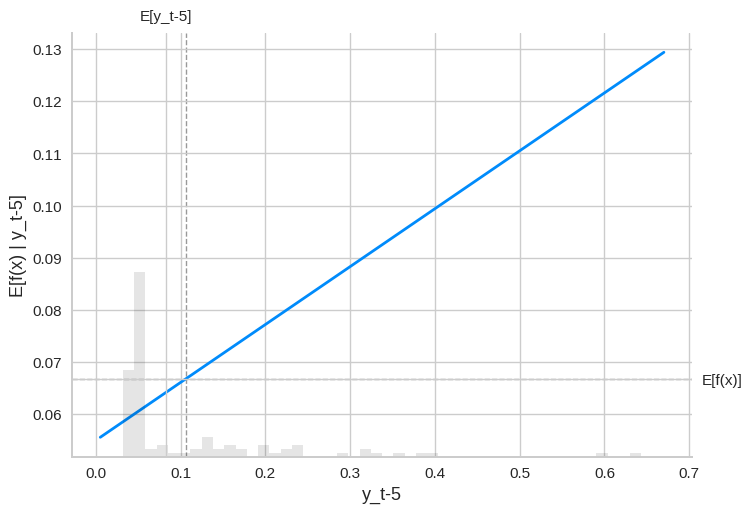

In [98]:
# so checking partial dependence plots provide the information of how much change happens
# in output that are a result of impact of changing the feature y_t-5

shap.partial_dependence_plot(
    "y_t-5",
    tuned_best.predict,
    test_data[numeric_features],
    ice=False,
    model_expected_value=True,
    feature_expected_value=True
)

> - The intersection of the grey lines and blue line indicates the center of the pdp plot w.r.t to the data distribution.

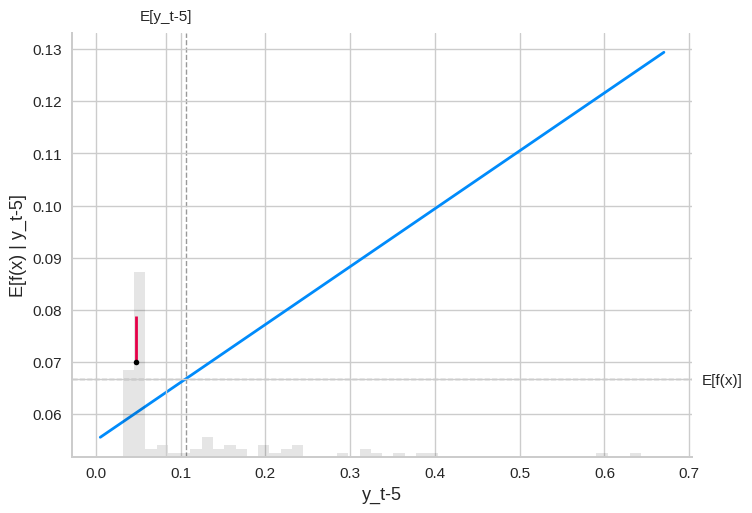

In [105]:
# using the shapley values
explainer = shap.Explainer(tuned_best.predict, validation_data[numeric_features])
shap_values = explainer(test_data[numeric_features])

shap.partial_dependence_plot(
    "y_t-5",
    tuned_best.predict,
    test_data[numeric_features],
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    shap_values=shap_values[45:46, :],
)

> - Here, for a random sample the `shap value` is difference between the expected model output and the partial dependence plot at the feature's value


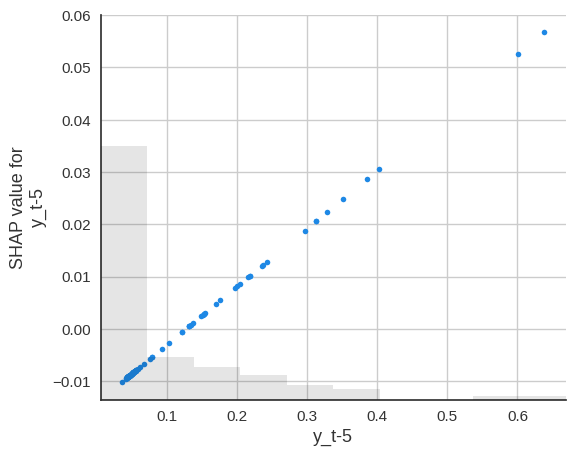

In [102]:
shap.plots.scatter(shap_values[:, "y_t-5"])

> - For a given feature it is possible to plot a mean centered value, if the shap values of the feature across the dataset is plotted. meaning, the shap values for a linear algorithm will follow the pdp plot line for a given featur

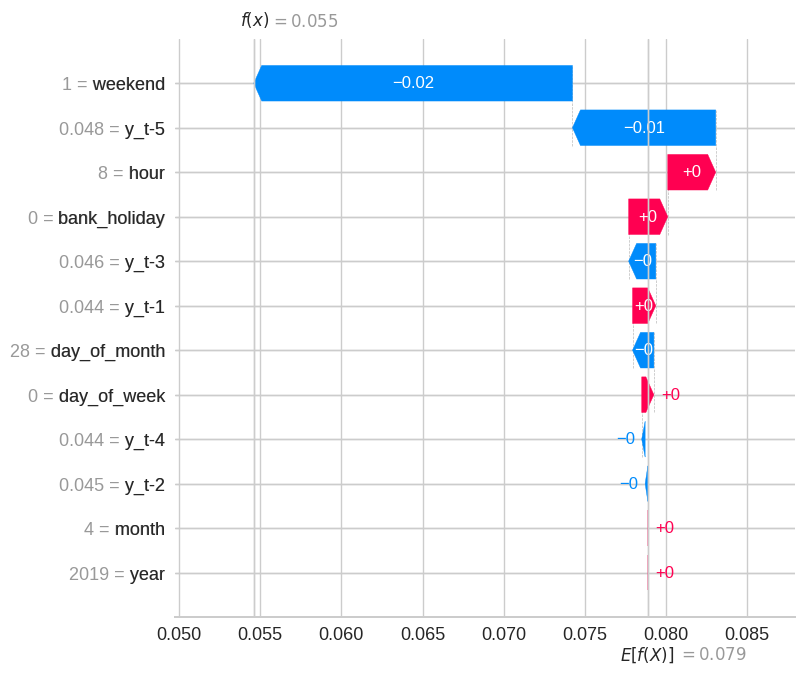

In [106]:
shap.plots.waterfall(shap_values[45], max_display=14)

> - Here, the `shapely waterfall_plot` shows how we get from shap_values.base_values to model.predict(X) for a given sample.
> - the trace starts from $E[f(X)] = 0.079$ with one variable $year=2019$. In a step by step fashion, the features of the random sample are added and the shift in the values are observed, until it reaches the model predict value of $f(X)=0.055$

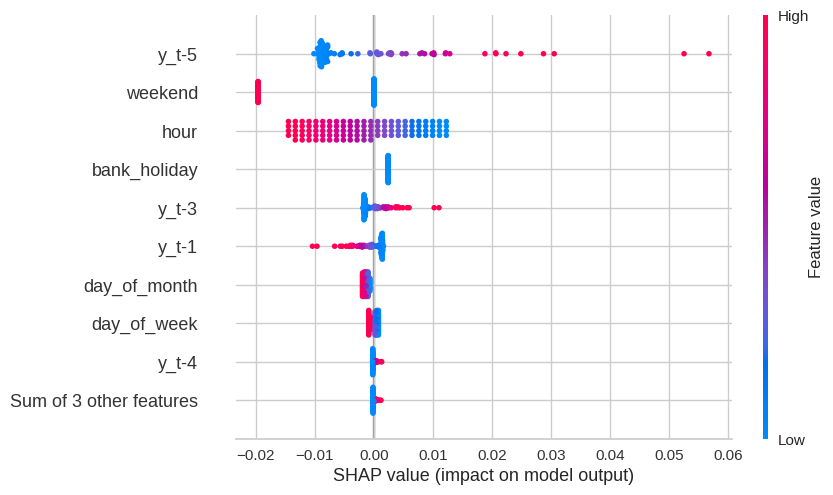

In [107]:
shap.plots.beeswarm(shap_values)

> - This is a beeswarm plot,
> - The plot visualizes distribution of SHAP values across features in dataset.
> - x axis represents  the shap values of individual data instances; provides info on feature influence. A wider spread or higher density of points indicates more significant variability or more substantial impact on the models prediction.
> - y axis represents the features and color coding associated to feature value, ranging from low to high. This color scheme helps in understanding patterns in the distribution f feature values across the instances

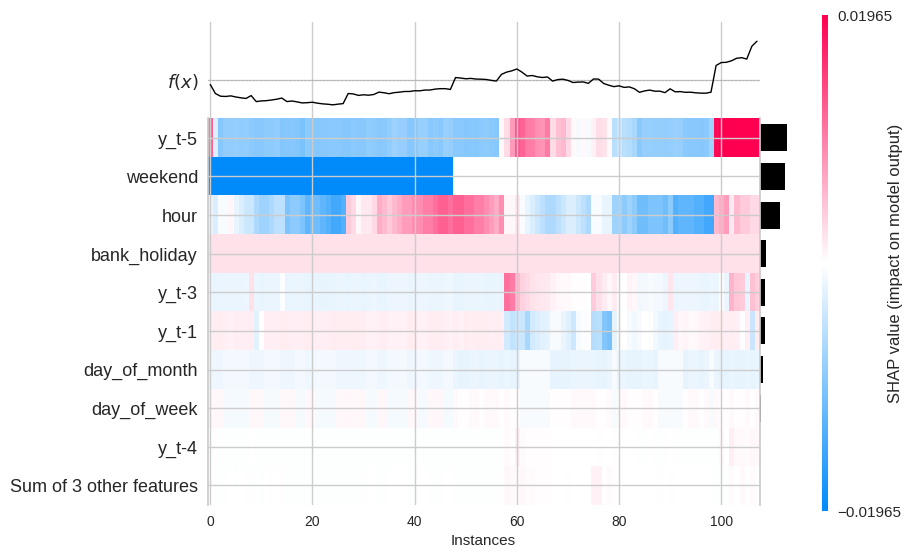

In [109]:
shap.plots.heatmap(shap_values)

> - The x axis represents the instances in the sample data.
> - y axis represents the features and the function prediction $f(X)$ at the top. Also color scheme to understand the shap value range on the instance.
> - Across the dataset instances, the higher the shap value ( red ) the more the contribution of the prediction for that instance

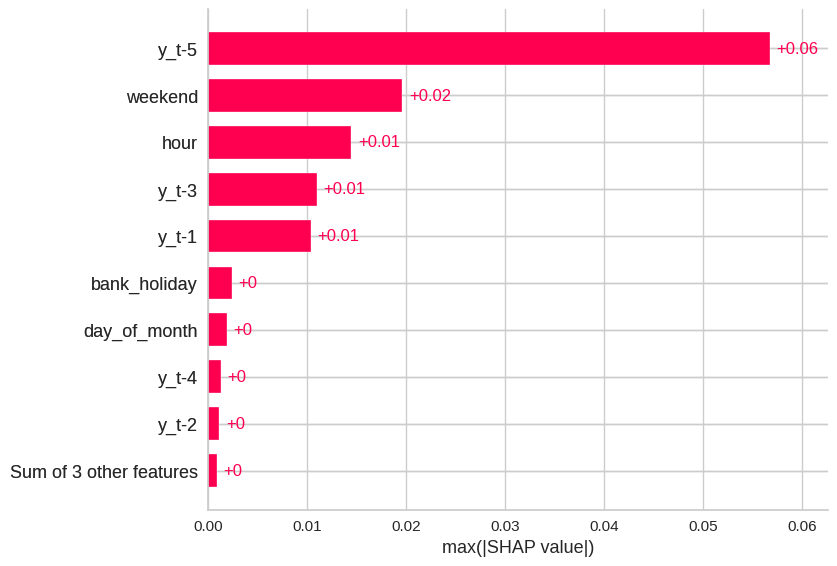

In [110]:
shap.plots.bar(shap_values.abs.max(0))

> - This is a feature importance bar plot.
> - Ordered in the higher to lower importance of the features.
> - x axis represents the maximum shap value corresponding the feature on y axis

> - Note: Shap + LSTM is an ongoing issue

 https://github.com/shap/shap/issues/3344
 https://github.com/shap/shap/issues/2808
> - the pkgs shap and tensorflow is not compatible with each other in the latest versions

> - Including the climatic features along with load features.
> - This necessary will not improve the models as the number of records / rows is less and increase in the data dimenions will result in high variance and noisy features, a curse of dimensionality.